# Módulo 3 - Monte Carlo Markov Chains e Análise Bayesiana de Dados

Vimos anteriormente que é difícil explorar o espaço de parâmetros a fim de encontrar a região preferida pelos dados.

Objetivos:
- Explorar o algoritmo de Metropolis-Hastings (Cobaya)
- Discutir o custo computacional e otimizações (paralelização, clusters)
- Obter vínculos nos parâmetros cosmológicos a partir dos dados (GetDist)
  - Vínculos marginalizados 1D
  - Vínculos 2D em *corner plots*
- Comparação de modelos via minimização
- Discutir algoritmos mais sofisticados (nested sampling, emuladores)

Vamos começar com um exemplo simples: em 1998, Adam Riess e colaboradores realizaram o trabalho de observação e análise de dados de supernovas que estabeleceu o modelo $\Lambda$CDM e ganhou o prêmio Nobel em 2011.

A Figura 6 do artigo https://arxiv.org/pdf/astro-ph/9805201 mostra que as supernovas favorecem uma expansão acelerada, indicando pela primeira vez a existência de energia escura.

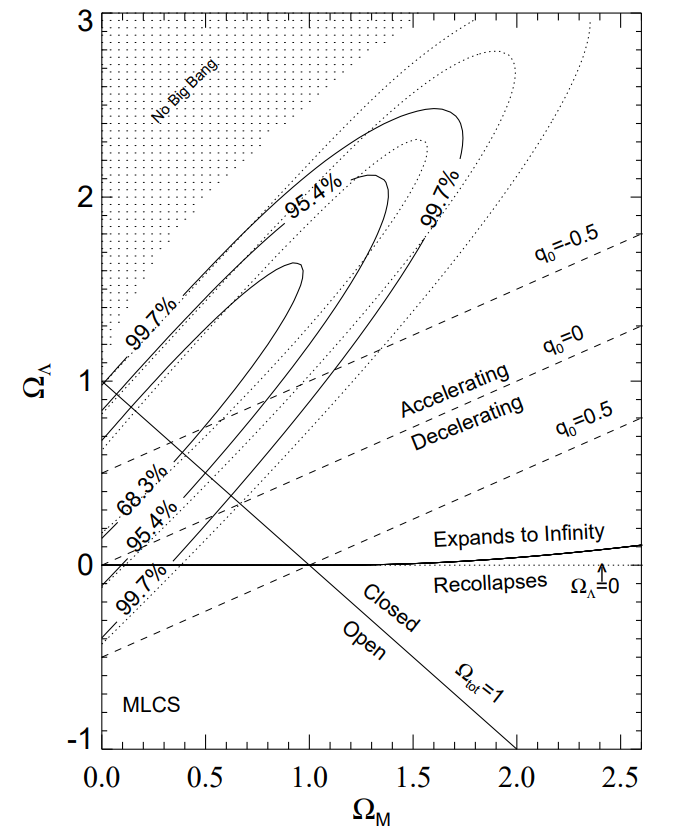

In [8]:
from IPython.display import Image
Image("./riess.png")

In [ ]:
from time import time
from random import uniform
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad

import getdist
from getdist import plots

import sn_riess as sn

In [10]:
def S_k(x, omegak):
    sqrt_omegak = np.sqrt(np.abs(omegak))
    if omegak == 0: return x
    elif omegak > 0: return np.sinh(sqrt_omegak*x)/sqrt_omegak
    elif omegak < 0: return np.sin(sqrt_omegak*x)/sqrt_omegak

def lum_dist(z, omegam, omegal, H0):
    omegak = 1 - omegam - omegal
    integrand = lambda z: 1/np.sqrt((1+z)**2*(1+omegam*z) - z*(2+z)*omegal)
    integral = quad(integrand, 0, z)[0]
    return sn.c*(1+z)/H0 * S_k(integral, omegak)

def chi2(model):
    om, ol, h0 = model
    if np.any(om*(1+sn.zs)**3 + (1 - om - ol)*(1+sn.zs)**2 + ol < 0): return np.nan
    lum_dists = np.array([lum_dist(z, *model) for z in sn.zs])
    mus_th = 5*np.log10(lum_dists) + 25
    return np.sum((mus_th - sn.mus)**2/(sn.sigmas**2 + sn.sigma_vel_disp**2))

In [ ]:
class MCMCWalker:
    """
        Helper class for managing MCMCs
    """
    def __init__(self):
        # Hard-coding an initial point for now
        initial_om = 0.3
        initial_ol = 0.7
        initial_h0 = 70
        initial_params = [initial_om, initial_ol, initial_h0]
        initial_chi2 = chi2(initial_params)
        if initial_chi2 == np.nan:
            self.__init__()
            return
        initial_sample = {
            'params': initial_params,
            'chi2': initial_chi2,
            'weight': 1,
        }
        self.samples = [initial_sample]

    def accept_sample(self, params, chi2):
        sample = {
            'params': params,
            'chi2': chi2,
            'weight': 1
        }
        self.samples.append(sample)

    def step(self):
        while True:
            current_chi2 = self.samples[-1]['chi2']
            new_om = self.samples[-1]['params'][0] + uniform(-0.25, 0.25)
            new_ol = self.samples[-1]['params'][1] + uniform(-0.25, 0.25)
            new_h0 = self.samples[-1]['params'][2] + uniform(-2.0, 2.0)
            new_params = [new_om, new_ol, new_h0]
            if new_h0 < 60 or new_h0 > 80 or new_om < 0 or new_om > 1 or new_ol < -1 or new_ol > 3:
                # Reject point outside the prior
                self.samples[-1]['weight'] += 1
                continue
            new_chi2 = chi2(new_params)
            if new_chi2 == np.nan:
                # Reject points that have problematic chi2
                self.samples[-1]['weight'] += 1
                continue
            if new_chi2 < current_chi2:
                self.accept_sample(new_params, new_chi2)
                break
            else:
                r = uniform(0, 1)
                if r < np.exp(-(new_chi2 - current_chi2)/2):
                    self.accept_sample(new_params, new_chi2)
                    break
                else:
                    self.samples[-1]['weight'] += 1 # Increment weight
                    continue
    
    def gelman_rubin(self, n_split):
        all_params = np.array(
            [sample['params'] for sample in self.samples]
        )[:-(len(self.samples)%n_split)]
        np.random.shuffle(all_params)
        split_params = np.split(all_params, n_split)
        avg = np.mean(split_params, axis=1)
        std = np.std(split_params, axis=1)
        avg_of_std = np.mean(std, axis=0)
        std_of_avg = np.std(avg, axis=0)
        R_minus_one = std_of_avg/avg_of_std
        return np.max(R_minus_one)

def run_mcmc():
  w = MCMCWalker()
  print("Starting MCMC")
  start = time()
  while True:
      for _ in range(1000): w.step()
      R_minus_one = w.gelman_rubin(4)
      print(f"At {len(w.samples)} samples, R-1 = {R_minus_one}")
      if R_minus_one < 0.01: break 
  print(f"MCMC Converged! Took {time() - start:.2f} seconds")
  return w

In [ ]:
w = run_mcmc()

Starting MCMC


At 1001 samples, R-1 = 0.037483961990430345
At 2001 samples, R-1 = 0.04556642395566493
At 3001 samples, R-1 = 0.048334770733727134


/tmp/ipykernel_22996/1540132177.py:17: RuntimeWarning: invalid value encountered in log10
  mus_th = 5*np.log10(lum_dists) + 25


At 4001 samples, R-1 = 0.02232430955829877
At 5001 samples, R-1 = 0.02845328408223989
At 6001 samples, R-1 = 0.01882609845132989
At 7001 samples, R-1 = 0.037206453383735405
At 8001 samples, R-1 = 0.021988948597983192
At 9001 samples, R-1 = 0.022945550610259692
At 10001 samples, R-1 = 0.019868582832119865
At 11001 samples, R-1 = 0.019302256898768067
At 12001 samples, R-1 = 0.01736630245117688
At 13001 samples, R-1 = 0.04024826346957156
At 14001 samples, R-1 = 0.018276672696239255
At 15001 samples, R-1 = 0.018387192274774363
At 16001 samples, R-1 = 0.018753601852871407
At 17001 samples, R-1 = 0.02363189185496366
At 18001 samples, R-1 = 0.014396475694834002
At 19001 samples, R-1 = 0.022650187716241766
At 20001 samples, R-1 = 0.010339682802021999
At 21001 samples, R-1 = 0.004307545601064433
MCMC Converged! Took 59.57 seconds
Removed no burn in


## GetDist: Análise Estatística de MCMCs

O pacote [`getdist`](https://getdist.readthedocs.io/en/latest/) é usado para processar amostras de MCMCs e obter resultados estatísticos. A análise usa o almoritmo de **Kernel Density Estimation (KDE)** para transformar as amostras em uma distribuição contínua. Vamos utilizar o `getdist` para obter intervalos de confiança e corner plots.

In [ ]:
def getdist_chain(w):
    """
        Função auxiliar que transforma as amostras cruas em um objeto `getdist.MCSamples`
        A função também define parâmetros derivados `q0` e `Omega_k`
    """
    mcmc = getdist.MCSamples(
    samples=np.array([sample['params'] + [sample['chi2']] for sample in w.samples]),
    weights=np.array([sample['weight'] for sample in w.samples]),
    names=["Omega_m", "Omega_Lambda", "H0", "chi2"],
    labels=["\\Omega_m", "\\Omega_\\Lambda", "H_0", "\\chi^2"],
    ranges={"Omega_m": (0, None)}
    )
    mcmc.removeBurn(0.3)
    mcmc.addDerived(mcmc["Omega_m"]/2 - mcmc["Omega_Lambda"], name="q0", label="q_0")
    mcmc.addDerived(1 - mcmc["Omega_Lambda"] - mcmc["Omega_m"], name="Omega_k", label="\\Omega_k")
    return mcmc

chain = sn.getdist_chain(w)

Removed no burn in


In [13]:
print("1D confidence intervals (68%):")
for param in ["H0", "Omega_m", "Omega_Lambda", "q0", "Omega_k"]:
  print(chain.getInlineLatex(param, limit=1))

1D confidence intervals (68%):
H_0 = 65.1\pm 1.2
\Omega_m < 0.519
\Omega_\Lambda = 0.91^{+0.34}_{-0.42}
q_0 = -0.71\pm 0.28
\Omega_k = -0.31^{+0.76}_{-0.48}


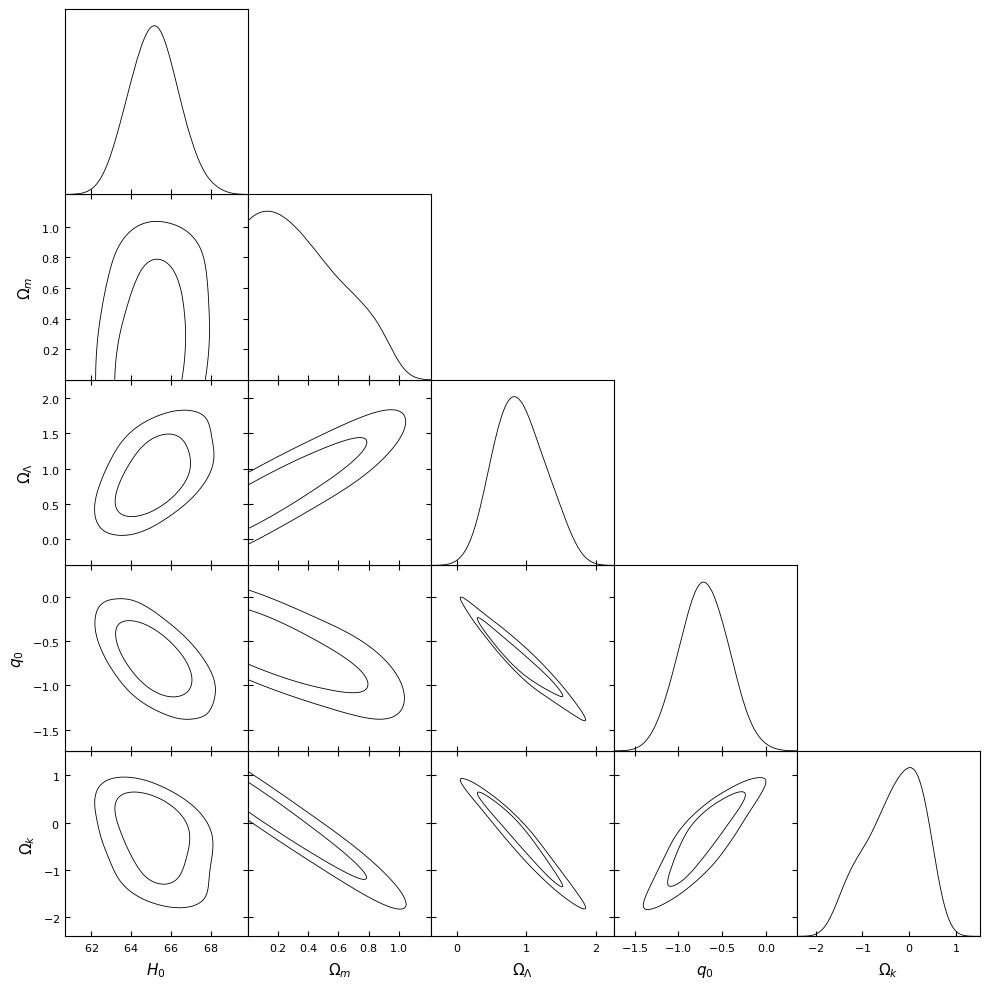

In [21]:
p = getdist.plots.get_subplot_plotter()
p.triangle_plot(
    chain,
    params=["H0", "Omega_m", "Omega_Lambda", "q0", "Omega_k"]
)

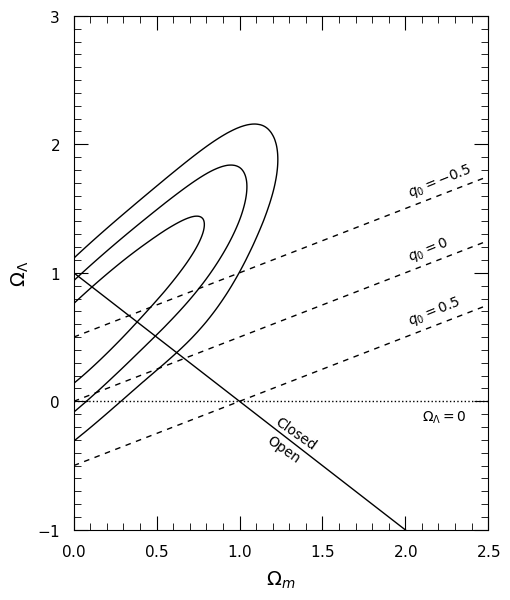

In [ ]:
def plot_chain(chain):
    """
        Função auxiliar que reproduz a Figura do artigo
    """
    g = plots.get_single_plotter(width_inch=5, ratio=30/25)
    g.settings.num_plot_contours = 3
    ax = g.get_axes()
    chain.updateSettings({"contours": [0.68, 0.95, 0.997]})
    g.plot_2d(chain, "Omega_m", "Omega_Lambda", ls='-', lws=1)
    ax.set_xlim([0, 2.5])
    ax.set_ylim([-1, 3])

    # Deceleration parameter lines
    om = np.linspace(0, 2.5, 50)
    ol = om/2 # q_0 = 0
    ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
    ax.text(2.0, ol[-7], r"$q_0 = 0$", rotation=22)
    ol = om/2 - 0.5 # q_0 = 0.5
    ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
    ax.text(2.0, ol[-7], r"$q_0 = 0.5$", rotation=22)
    ol = om/2 + 0.5 # q_0 = -0.5
    ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
    ax.text(2.0, ol[-7], r"$q_0 = -0.5$", rotation=22)

    # Closed/Open line
    ol = 1 - om
    ax.plot(om, ol, color="black", ls="-", lw=1)
    ax.text(1.2, ol[-23], "Closed", rotation=-35)
    ax.text(1.15, ol[-21], "Open", rotation=-35)

    # Omega_Lambda = 0
    ol = 0*om
    ax.plot(om, ol, color="black", ls=":", lw=1)
    ax.text(2.1, -0.15, r"$\Omega_\Lambda = 0$")

    ax.set_xticks(np.arange(0, 2.51, 0.1), minor=True)
    ax.set_yticks(np.arange(-1, 3, 0.1), minor=True)
    ax.tick_params(direction="in", length=10, top=True, right=True, pad=10)
    ax.tick_params(which="minor", direction="in", length=5, top=True, right=True)
    g.export("riess_reproduction.pdf")

plot_chain(chain)

# Análise de Comparação de Modelos
Temos uma MCMC para os dados de supernovas assumindo o modelo $\Lambda$CDM com curvatura e energia escura. Será que a energia escura é realmente necessária?

Vamos comparar alguns modelos:
- Einstein-de Sitter ($\Omega_m = 1$, $\Omega_k = \Omega_\Lambda = 0$),
- Apenas matéria e curvatura, $\Omega_\Lambda = 0$,
- $\Lambda$CDM com curvatura,
- $\Lambda$CDM sem curvatura.

Observe que o primeiro modelo é uma generalização dos outros dois.

Técnicas de seleção de modelo se baseiam no **máximo global** da likelihood. Vamos usar `scipy` para minimizar a função $\chi^2$.

In [22]:
initial = chain.samples[np.argmin(chain["chi2"])][:3]
r_eds       = minimize(chi2, initial, constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[1]}, {'type': 'eq', 'fun': lambda x: x[0] - 1}])
r_eds_curv  = minimize(chi2, [0.3, 0.7, 65], constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[1]}])
r_lcdm_curv = minimize(chi2, initial, constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}])
r_lcdm_flat = minimize(chi2, [0.3, 0.7, 65], constraints=[{'type': 'ineq', 'fun': lambda x: x[0]}, {'type': 'eq', 'fun': lambda x: x[0] + x[1] - 1}])

In [23]:
print(f"Sem dark energy, sem curvatura: chi2 mínimo = {r_eds.fun:.4f}, parâmetros {r_eds.x}")
print(f"Sem dark energy, com curvatura: chi2 mínimo = {r_eds_curv.fun:.4f}, parâmetros {r_eds_curv.x}")
print(f"Com dark energy, sem curvatura: chi2 mínimo = {r_lcdm_flat.fun:.4f}, parâmetros {r_lcdm_flat.x}")
print(f"Com dark energy, com curvatura: chi2 mínimo = {r_lcdm_curv.fun:.4f}, parâmetros {r_lcdm_curv.x}")
print(f"Número de supernovas:", len(sn.all))

Sem dark energy, sem curvatura: chi2 mínimo = 63.4447, parâmetros [ 1.          0.         60.96018282]
Sem dark energy, com curvatura: chi2 mínimo = 37.2933, parâmetros [2.18238314e-15 0.00000000e+00 6.33182869e+01]
Com dark energy, sem curvatura: chi2 mínimo = 33.8520, parâmetros [ 0.23565181  0.76434819 65.12413672]
Com dark energy, com curvatura: chi2 mínimo = 33.7530, parâmetros [7.20539767e-03 4.78687098e-01 6.48726238e+01]
Número de supernovas: 37


Algumas observações:
- O que define um *bom fit*? A partir da expressão
\begin{equation}
  \chi^2 = \sum_i \frac{(d_i - t_i)^2}{\sigma_i^2},
\end{equation}
vemos que, se cada previsão teórica $t_i$ dista do dado observado $d_i$ em menos de um desvio padrão, então $\chi^2 < N_\mathrm{data}$, onde $N_\mathrm{data}$ é o número de elementos no seu *data vector*. No nosso caso, possuímos 37 supernovas! Logo, os resultados indicam um bom ajuste dos modelos aos dados observados.
- **Modelos mais gerais fitam melhor os dados.** O modelo com curvatura é uma generalização do modelo sem curvatura, adicionando mais um parâmetro. Nesses casos, é extremamente provável (estatisticamente falando) que os dados prefiram um parâmetro $\Omega_k \neq 0$.

Conclusão: embora o modelo com curvatura consiga se ajustar melhor aos dados, isso já é esperado. A pergunta é **se a melhora no ajuste vale o aumento na complexidade do modelo**.

Existem alguns métodos de seleção de modelos:
- Akaike Information Criterion (AIC): para um modelo $M$, definimos
\begin{equation}
  \mathrm{AIC}(M) = \chi^2_\mathrm{min} + 2N_\mathrm{params},
\end{equation}
onde $\chi^2_\mathrm{min}$ e $N_\mathrm{params}$ são, respectivamente, o mínimo global de $\chi^2$ assumindo o modelo $M$ e o número de parâmetros do modelo $M$. Modelos com menor $\mathrm{AIC}$ são preferíveis. A regra heurística aqui é a que **cada parâmetro adicional deve diminuir $\chi^2$ em pelo menos 2 unidades.**
- Bayesian Information Criterion (BIC): para um modelo $M$, definimos
\begin{equation}
  \mathrm{BIC}(M) = \chi^2_\mathrm{min} + N_\mathrm{params}\ln(N_\mathrm{data}),
\end{equation}
onde $\chi^2_\mathrm{min}$ e $N_\mathrm{params}$ são, respectivamente, o mínimo global de $\chi^2$ assumindo o modelo $M$ e o número de parâmetros do modelo $M$. Modelos com menor $\mathrm{AIC}$ são preferíveis. A regra heurística aqui é a que **cada parâmetro adicional deve diminuir $\chi^2$ em pelo menos 2 unidades.**
- Fator de Bayes: o mais complicado dos métodos. O teorema de Bayes implica que
  \begin{equation}
    p(\theta | \mathrm{data}, M) = \frac{p(\mathrm{data} | \theta, M)p(\theta | M)}{p(\mathrm{data} | M)}.
  \end{equation}
  O denominador $p(\mathrm{data} | M)$ é a *evidência bayesiana* do modelo, e é igual à integral do numerador (*i.e.* likelihood vezes prior) sobre o espaço de parâmetros. Para dois modelos $M$ e $N$, o fator de Bayes é definido como
  \begin{equation}
    Z = \log \left(\frac{p(\mathrm{data} | M)}{p(\mathrm{data} | N)}\right).
  \end{equation}
  A interpretação do fator de Bayes é dada pela escala de Jeffreys:
  - $|Z| < 0.5$: inconclusivo;
  - $0.5 < |Z| < 1$: evidência fraca;
  - $1 < |Z| < 2$: evidência moderada;
  - $|Z| > 2$: evidência forte;
  
  O sinal de $Z$ indica o modelo favorecido: $Z > 0$ favorece o modelo $M$ enquanto $Z < 0$ favorece $N$.

In [24]:
aic_eds = r_eds.fun + 2*1
aic_eds_curv = r_eds_curv.fun + 2*2
aic_lcdm_flat = r_lcdm_flat.fun + 2*2
aic_lcdm_curv = r_lcdm_curv.fun + 2*3
bic_eds = r_eds.fun + np.log(len(sn.all))*1
bic_eds_curv = r_eds_curv.fun + np.log(len(sn.all))*2
bic_lcdm_flat = r_lcdm_flat.fun + np.log(len(sn.all))*2
bic_lcdm_curv = r_lcdm_curv.fun + np.log(len(sn.all))*3
print(f"Sem dark energy, sem curvatura: AIC = {aic_eds}, BIC = {bic_eds}")
print(f"Sem dark energy, com curvatura: AIC = {aic_eds_curv}, BIC = {bic_eds_curv}")
print(f"Com dark energy, sem curvatura: AIC = {aic_lcdm_flat}, BIC = {bic_lcdm_flat}")
print(f"Com dark energy, com curvatura: AIC = {aic_lcdm_curv}, BIC = {bic_lcdm_curv}")

Sem dark energy, sem curvatura: AIC = 65.44467121905366, BIC = 67.05558913169789
Sem dark energy, com curvatura: AIC = 41.29330433649237, BIC = 44.51514016178082
Com dark energy, sem curvatura: AIC = 37.85195304825705, BIC = 41.0737888735455
Com dark energy, com curvatura: AIC = 39.75303544560009, BIC = 44.58578918353277


Usando o AIC e o BIC, o modelo preferido é o $\Lambda$CDM sem curvatura! Embora o $\Lambda$CDM com curvatura consiga prover o melhor ajuste aos dados, a complexidade adicional não vale a pena dada a pequena melhora.

# Cobaya

`Cobaya` é um *framework* de análise Bayesiana de dados cosmológicos. O código oferece:
- *Likelihoods* de vários dados (CMB, supernovas, BAO...)
- Interface com códigos teóricos comuns como `CLASS` e `CAMB`
- Implementação de Metropolis-Hastings e minimizadores

O exemplo de supernovas é um caso simplista: apenas três parâmetros livres e a previsão teórica pode ser calculada muito rapidamente. Em análises reais:
- A previsão teórica precisa de seis parâmetros cosmológicos mais dezenas de *parâmetros de nuisance* (necessários para modelar erros sistemáticos do experimento). Quanto mais parâmetros livres na MCMC, mais passos são necessários para a convergência. No nosso exemplo, a cadeia converge em aproximadamente 20k amostras; cadeias reais costumam convergir com ~200k+ amostras
- A previsão teórica passa pela solução das equações de Einstein-Boltzmann (perturbações lineares). Distâncias são facilmente computáveis, mas a solução das equações de perturbação é mais complexa, e demora O(1s)

# Paralelização

Entender paralelização é importante para lidar com computações em grande escala. O processador do computador possui múltiplos núcleos, e programas comuns utilizam apenas um núcleo. Isso permite que o computador faça várias tarefas concorrentemente.

Podemos, no entanto, programar códigos para que usem mais de um núcleo ao desempenhar tarefas. Por exemplo, se duas partes de cálculo podem ser feitas independentemente, então podemos "entregá-las" a núcleos diferentes e em seguida combinar o resultado.

Existem dois modelos de paralelização:
- *Multithreading*: ocorre quando um processo (no sentido computacional, ou seja, cada entrada do "gerenciador de tarefas") utiliza mais de um núcleo do processador. Os núcleos compartilham da mesma memória, ou seja, eles podem operar sobre os mesmos dados.
- *Multiprocessing*: ocorre quando um programa abre mais de um processo no computador, cada processo usando apenas um núcleo. Processos não compartilham memória, mas podem se comunicar a fim de trocar informações.

Vários programas se utilizam das duas técnicas para otimizar seus resultados. No caso do `Cobaya`:
- Cada cadeia consiste em múltiplos "walkers" que percorrem o espaço de parâmetros. **Cada walker consiste em um processo (multiprocessing)**. Periodicamente, os walkers trocam informação entre si para verificar a convergência da cadeia.
- Cada walker precisa chamar o `CLASS` para obter a previsão teórica e calcular a likelihood. O `CLASS` resolve o sistema de equações de Einstein-Boltzmann para diferentes valores de `k` (número de onda de Fourier). Por serem equações lineares, cada `k` gera um sistema de equações independentes, **que são resolvidas em paralelo usando multithreading**.

# Clusters

Paralelização consiste em técnicas que tiram vantagem de recursos computacionais; no entanto, nossos computadores pessoais possuem poucos núcleos. Felizmente, universidades possuem computadores grandes com vários processadores: os *clusters*.

MCMCs são tarefas computacionais caras que demoram dias para completar, mesmo empregando muitos processadores. *Clusters* fornecem uma ferramenta para conduzir computações caras (e a universidade paga o custo da eletricidade). O departamento de Cosmologia e Interações Fundamentais (COSMO) possui o CHE, um pequeno cluster que atende às necessidades do grupo.